## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 215MB/s]


In [4]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=baba6e74-c6fa-4880-8e35-6b15858a030c
To: /content/coco_captions.npy
100% 415M/415M [00:01<00:00, 213MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

In [6]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [7]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=1.77s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [85]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
# print('Captions:', captions_np)

In [130]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))
# captions_flat

Total captions: 202520


In [131]:
cap_path = '/content/drive/MyDrive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [132]:
img_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [133]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

### Task 1

In [134]:
caption_embeddings_new = np.reshape(caption_embeddings, (-1, 512))

print(caption_embeddings_new)

[[-2.9846387e-02 -2.7121352e-02  5.2404514e-05 ...  4.0988393e-02
   3.2700416e-02 -2.7879201e-02]
 [-3.5480466e-02 -3.9461046e-02 -1.0539140e-02 ...  5.0266604e-03
  -1.4535394e-03 -7.7456799e-03]
 [-7.0352077e-02 -1.0378881e-02 -8.2088262e-03 ...  3.5793733e-02
   2.7698692e-02 -3.0689629e-02]
 ...
 [ 2.7078019e-02 -3.0891633e-02 -2.1767665e-03 ...  2.4385253e-02
  -1.4748705e-02  1.9683165e-03]
 [ 2.4439493e-02 -1.2335888e-02 -3.3050556e-02 ...  4.1512296e-02
  -3.3382390e-02 -7.2173653e-03]
 [ 2.0983204e-02 -3.8852878e-02  2.1219205e-03 ...  7.2339885e-02
  -2.3649579e-02 -3.0075375e-02]]


In [135]:
k = 5
def createFaissIndex(embeddings):
  # creates index from embeddings
  dimensions = embeddings.shape[1]
  index = faiss.IndexFlatIP(dimensions)
  index.add(embeddings)
  return index

def getKnn(queryVector, index, k):
  distances, neighbourIndices = index.search(queryVector, k)
  return distances, neighbourIndices

imageIndex = createFaissIndex(image_embeddings)
captionIndex = createFaissIndex(caption_embeddings_new)
imageDistances, imageNeighbourIndices = getKnn(image_embeddings, imageIndex, k+1)
print(imageDistances)


[[1.0001048  0.78265786 0.77542835 0.769514   0.7572037  0.7564074 ]
 [1.0006994  0.8738807  0.86978817 0.85849833 0.8564263  0.8530035 ]
 [0.99967307 0.85474044 0.79905784 0.79868966 0.77817035 0.7742204 ]
 ...
 [1.0004672  0.8553455  0.84840286 0.84577364 0.8381327  0.83253634]
 [1.000154   0.8963151  0.8952983  0.8934312  0.8785075  0.8748094 ]
 [1.0005071  0.8378865  0.83325493 0.8299656  0.82923114 0.82655317]]


In [136]:
imageDistances = imageDistances[:, 1:]

print(imageDistances)

[[0.78265786 0.77542835 0.769514   0.7572037  0.7564074 ]
 [0.8738807  0.86978817 0.85849833 0.8564263  0.8530035 ]
 [0.85474044 0.79905784 0.79868966 0.77817035 0.7742204 ]
 ...
 [0.8553455  0.84840286 0.84577364 0.8381327  0.83253634]
 [0.8963151  0.8952983  0.8934312  0.8785075  0.8748094 ]
 [0.8378865  0.83325493 0.8299656  0.82923114 0.82655317]]


In [137]:
imageNeighbourIndices = imageNeighbourIndices[:, 1:]

print(imageNeighbourIndices)

[[26758  9223 30435 17713 15097]
 [ 6112 20305 21554  8423 34172]
 [29457  3501 38532 24470  8761]
 ...
 [31887  5551 36753 28715  5596]
 [ 4792  9496 33609 26409 10378]
 [ 1738 26099 34026   860 10452]]


In [138]:
def calcQuery(img, caption_embeddings, indexArr):
    # Initialize the query vector
    queryVector = np.zeros(caption_embeddings.shape[2])
    products = []

    # Calculate the sum of caption embeddings for the nearest neighbors of the image
    for neighbour in range(0, k):
      # captionSum = np.sum(caption_embeddings[img], axis = 0)
      captionSum = np.sum(caption_embeddings[indexArr][neighbour], axis = 0)

      product = imageDistances[img][neighbour] * captionSum
      products.append(product)

    products = np.array(products)
    # Calculate the query vector
    queryVector = np.sum(products, axis=0)
    return queryVector / (5 * k)


In [139]:
predicted_captions = []
queries=[]

for img in range(len(imageNeighbourIndices)):
  # calc query vector
  imageQuery = calcQuery(img, caption_embeddings, imageNeighbourIndices[img])
  queries.append(imageQuery)

queries = np.array(queries)
queries.shape

closestCaptionDist, closestCapIndex = captionIndex.search(np.array(queries), 6)
closestCaptionDist, closestCapIndex

(array([[0.5404791 , 0.53656125, 0.5361124 , 0.5361124 , 0.5361124 ,
         0.5356022 ],
        [0.67901707, 0.6786597 , 0.6758744 , 0.67578906, 0.6757606 ,
         0.67549986],
        [0.5672302 , 0.5665407 , 0.56585956, 0.56320846, 0.5620403 ,
         0.5610705 ],
        ...,
        [0.7444427 , 0.74317205, 0.7426694 , 0.741871  , 0.74185324,
         0.7412986 ],
        [0.7665291 , 0.76588213, 0.7642461 , 0.76309633, 0.7626332 ,
         0.76107204],
        [0.68837464, 0.68118453, 0.67897046, 0.6761712 , 0.6733017 ,
         0.67264444]], dtype=float32),
 array([[ 23083,  53330,  65174,  34991,  28161,  57556],
        [187484, 125576,  87612, 109529,  66978, 171497],
        [ 90968,  90966, 175425,   5811,  75779,  75776],
        ...,
        [173356,  94293,  20888, 189563,  94721, 193063],
        [  2067, 131721,  36122, 161516,  35559,  18915],
        [ 87411,  20267,  87446, 129866,  87449,  87445]]))

In [140]:
def get_index_within_range(index_pair, image_index):
  start_range = image_index * 5
  end_range = image_index * 5 + 4
  for idx in index_pair:
      if not (start_range <= idx <= end_range):
          return idx

predictedCaptions = []

for idx in range(len(closestCapIndex)):
  found_index = get_index_within_range(closestCapIndex[idx], idx)
  predictedCaptions.append(captions_flat[found_index])

predictedCaptions

['A dog that is sitting on a bed.',
 'a motorcycle parked near other bikes and people near by',
 'A dog on a leash sitting next to a bench',
 'A kitchen with numerous things in the room. \n',
 'there is a group of three giraffes standing together.',
 'The picture shows a living room with a few sofas, a tv, and a table.',
 'A bird perched on the branch of a tree.',
 'A kitchen area that has items on the counter tops. ',
 'A baseball player is swinging the bat at a ball.',
 'a table with some dishes with food on it',
 'a cat sitting in the sink in the bathroom',
 'Several people standing around playing video games together.',
 'A large building on the corner of a city street.',
 'A bottle of wine and a glass on a table.',
 'A ADULT BROWN BEAR IS IN THE GRASS',
 'A man enjoys cooking food in a pan',
 'Two people sitting on a bench and talking.  ',
 'A kitchen with a window and bunch of kitchen furniture in it',
 'A baseball team plays a game on the field.',
 'A street scene with a close o

In [141]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

print('accuracy_v2:',accuracy_v2(predictedCaptions, captions_np))

accuracy_v2: 0.07564238393476262


### Task 2

In [142]:
accuracies = []
for k in range(2,12,2):
  imageDistances, imageNeighbourIndices = getKnn(image_embeddings, imageIndex, k+1)
  imageDistances = imageDistances[:, 1:]
  imageNeighbourIndices = imageNeighbourIndices[:, 1:]

  predicted_captions = []
  queries=[]

  for img in range(len(imageNeighbourIndices)):
    # calc query vector
    imageQuery = calcQuery(img, caption_embeddings, imageNeighbourIndices[img])
    queries.append(imageQuery)

  queries = np.array(queries)
  queries.shape

  closestCaptionDist, closestCapIndex = captionIndex.search(np.array(queries), 6)

  for idx in range(len(closestCapIndex)):
    found_index = get_index_within_range(closestCapIndex[idx], idx)
    predicted_captions.append(captions_flat[found_index])

  acc  = accuracy_v2(predicted_captions,captions_np)
  accuracies.append(acc)
  print("K = ", k , 'accuracy_v2:', acc)



K =  2 accuracy_v2: 0.07395007479303525
K =  4 accuracy_v2: 0.07577195884666
K =  6 accuracy_v2: 0.0761249949903762
K =  8 accuracy_v2: 0.075145866420161
K =  10 accuracy_v2: 0.07525366573965671


### Task 3

In [143]:
k = 4
def createFaissIndex(embeddings):
  # creates index from embeddings
  dimensions = embeddings.shape[1]
  index = faiss.IndexFlatL2(dimensions)
  index.add(embeddings)
  return index

def getKnn(queryVector, index, k):
  distances, neighbourIndices = index.search(queryVector, k)
  return distances, neighbourIndices

imageIndex = createFaissIndex(image_embeddings)
captionIndex = createFaissIndex(caption_embeddings_new)
imageDistances, imageNeighbourIndices = getKnn(image_embeddings, imageIndex, k+1)
# print(imageDistances)

imageDistances, imageNeighbourIndices = getKnn(image_embeddings, imageIndex, k+1)
imageDistances = imageDistances[:, 1:]
imageNeighbourIndices = imageNeighbourIndices[:, 1:]

predicted_captions = []
queries=[]

for img in range(len(imageNeighbourIndices)):
  # calc query vector
  imageQuery = calcQuery(img, caption_embeddings, imageNeighbourIndices[img])
  queries.append(imageQuery)

queries = np.array(queries)
queries.shape

closestCaptionDist, closestCapIndex = captionIndex.search(np.array(queries), 6)

for idx in range(len(closestCapIndex)):
  found_index = get_index_within_range(closestCapIndex[idx], idx)
  predicted_captions.append(captions_flat[found_index])

acc  = accuracy_v2(predicted_captions,captions_np)


In [144]:
print("Accuracy with L2 for K = 4 =", acc)

Accuracy with L2 for K = 4 = 0.07450751294500399


In [149]:
k = 4

def createFaissIndex(embeddings):
  nlist = 100
  quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])
  index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], nlist)
  index.train(image_embeddings)
  index.add(image_embeddings)
  return index

def getKnn(queryVector, index, k):
  distances, neighbourIndices = index.search(queryVector, k)
  return distances, neighbourIndices

imageIndex = createFaissIndex(image_embeddings)
captionIndex = createFaissIndex(caption_embeddings_new)
imageDistances, imageNeighbourIndices = getKnn(image_embeddings, imageIndex, k+1)
# print(imageDistances)

imageDistances, imageNeighbourIndices = getKnn(image_embeddings, imageIndex, k+1)
imageDistances = imageDistances[:, 1:]
imageNeighbourIndices = imageNeighbourIndices[:, 1:]

predicted_captions = []
queries=[]

for img in range(len(imageNeighbourIndices)):
  # calc query vector
  imageQuery = calcQuery(img, caption_embeddings, imageNeighbourIndices[img])
  queries.append(imageQuery)

queries = np.array(queries)
queries.shape

closestCaptionDist, closestCapIndex = captionIndex.search(np.array(queries), 6)

for idx in range(len(closestCapIndex)):
  found_index = get_index_within_range(closestCapIndex[idx], idx)
  predicted_captions.append(captions_flat[found_index])

acc  = accuracy_v2(predicted_captions,captions_np)


<ipython-input-138-dddf833677ba>:11: RuntimeWarning: overflow encountered in multiply
  product = imageDistances[img][neighbour] * captionSum
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/l

In [151]:
print("Accuracy with IndexIVFFlat for K = 4 =", acc)


Accuracy with IndexIVFFlat for K = 4 = 0.0022104531330708267


Here we see that using the FlatL2 (Euclidean Distance) index we get a model that has a similar compute time and accuracy as FlatIP. However, on using IndexIVFFlat we get a model that has a much lower compute time but also compromises on accuracy. This shows that though the model trains faster, it performs worse overall.


### Task 4


Ground Truth Captions:  ['This wire metal rack holds several pairs of shoes and sandals'
 'A dog sleeping on a show rack in the shoes.'
 'Various slides and other footwear rest in a metal basket outdoors.'
 'A small dog is curled up on top of the shoes'
 'a shoe rack with some shoes and a dog sleeping on them']
Predicted Caption:  two dogs are laying in a bed together


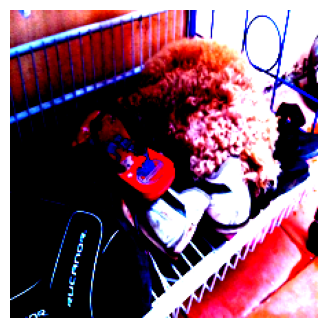

Ground Truth Captions:  ['A motorcycle parked in a parking space next to another motorcycle.'
 'An old motorcycle parked beside other motorcycles with a brown leather seat.'
 'Motorcycle parked in the parking lot of asphalt.'
 'A close up view of a motorized bicycle, sitting in a rack. '
 'The back tire of an old style motorcycle is resting in a metal stand. ']
Predicted Caption:  A motorcycle on display near people standing around and talking.


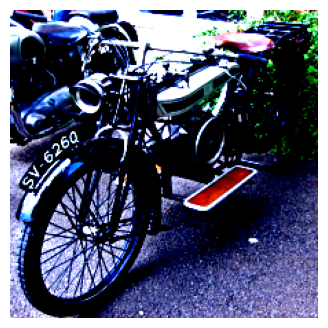

Ground Truth Captions:  ['A picture of a dog laying on the ground.'
 'Dog snoozing by a bike on the edge of a cobblestone street'
 'The white dog lays next to the bicycle on the sidewalk.'
 'a white dog is sleeping on a street and a bicycle'
 'A puppy rests on the street next to a bicycle.']
Predicted Caption:  a dog sitting on a side walk with a bike near by


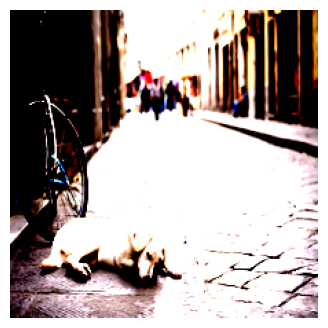

Ground Truth Captions:  ['A loft bed with a dresser underneath it.'
 'A bed and desk in a small room.' 'Wooden bed on top of a white dresser.'
 'A bed sits on top of a dresser and a desk.'
 'Bunk bed with a narrow shelf sitting underneath it. ']
Predicted Caption:  A kitchen with numerous things in the room. 



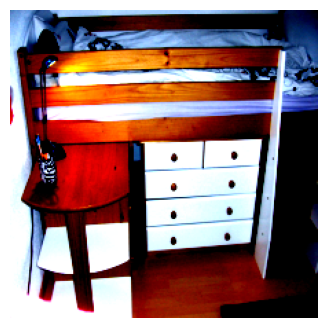

Ground Truth Captions:  ['Two giraffes in a room with people looking at them.'
 'Two giraffe standing next to each other in a room.'
 'The giraffe is being kept by itself indoors. '
 'A man and woman staring at two giraffes through a window.'
 'a giraffe in a enclosed area is watched by some people']
Predicted Caption:  there is a group of three giraffes standing together.


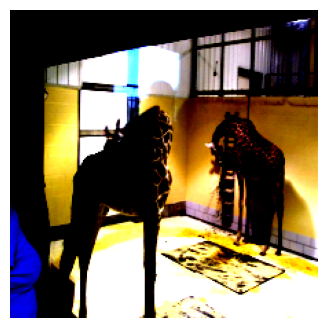

In [145]:
# for k = 10
for i in range(0,5):
  groundTruthCapt = captions_np[i]
  pc = predicted_captions[i]
  print("Ground Truth Captions: ", groundTruthCapt)
  print("Predicted Caption: ", pc)

  img, target = coco_dset[i]
  plt.figure(figsize=(4, 4))
  img_np = img.permute(1, 2, 0)
  plt.imshow(img_np)
  plt.axis('off')
  plt.show()
